In [3]:
import glob
import numpy as np
from PIL import *
import PIL.Image

In [4]:
filelist = glob.glob('CROPAUG2/glu/*.jpg')              #change '/'
glu = np.array([np.array(Image.open(fname)) for fname in filelist])
print(glu.shape)

(40, 597, 597, 3)


In [5]:
filelist = glob.glob('CROPAUG2/nglu/*.jpg')         #change '/'
nonglu = np.array([np.array(Image.open(fname)) for fname in filelist])
print(nonglu.shape)

(50, 597, 597, 3)


In [6]:
X = np.concatenate((glu,nonglu),axis=0)
print(X.shape)
print(X[1,:].shape)

(90, 597, 597, 3)
(597, 597, 3)


In [7]:
gluL = np.array([1 for i in range(40)])
nongluL = np.array([0 for i in range(50)])
y = np.concatenate((gluL,nongluL),axis=0)
print(y.shape)

(90,)


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_test)

(72, 597, 597, 3) (18, 597, 597, 3) (72,) (18,)
[0 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1 1 1]


In [10]:
from keras.models import Sequential
from keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dropout,Dense,LeakyReLU
from keras.layers.core import Activation, Dense
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', input_shape=X_train.shape[1:]))
# model.add(Activation('sigmoid'))
model.add(LeakyReLU(alpha=0.))
model.add(Dropout(0.02))
model.add(Conv2D(32, (3,3),padding='valid'))
# model.add(Activation('sigmoid'))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.02))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
# model.add(Activation('sigmoid'))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.02))
model.add(Conv2D(64, (3,3)))
# model.add(Activation('sigmoid'))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.04))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
# model.add(Activation('sigmoid'))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.04))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3)))
# model.add(Activation('sigmoid'))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.08))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3)))
# model.add(Activation('sigmoid'))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.08))
model.add(Conv2D(128, (3,3)))
# model.add(Activation('sigmoid'))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, (3,3)))
# model.add(Activation('sigmoid'))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.1))
model.add(Conv2D(256, (3,3)))
# model.add(Activation('sigmoid'))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, (1,1)))
# model.add(Activation('sigmoid'))
model.add(LeakyReLU(alpha=0.05))
model.add(Dropout(0.10))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('sigmoid'))
# model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(Dense(16))
model.add(Activation('sigmoid'))
# model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.10))
model.add(Dense(2, activation='sigmoid'))

In [11]:
model.output_shape

(None, 2)

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 597, 597, 32)      896       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 597, 597, 32)      0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 597, 597, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 595, 595, 32)      9248      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 595, 595, 32)      0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 595, 595, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 297, 297, 32)      0         
__________

# DATA GENERATION

In [13]:
from keras.utils import np_utils
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')
num_classes = 2
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True,
                             rotation_range=15, width_shift_range=0.1,
                             height_shift_range=0.1,zoom_range=0.1,
                             fill_mode='constant', cval=0.0)

datagen.fit(X_train)
print(y_train[0])



[1. 0.]


In [14]:
from keras.optimizers import *

from keras import optimizers
# sgd = optimizers.SGD(lr=0.0003, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='mean_squared_error', optimizer=sgd, metrics = ['accuracy'])
# opt = Adam(lr=0.001)

# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# EPOCHS = 100
# INIT_LR = 1e-4
# BS = 32
# opt = Adam(lr=INIT_LR)
model.compile(optimizer=SGD(0.003),loss="binary_crossentropy",metrics=["accuracy"])
# model.compile(loss='binary_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])
# train the network

In [15]:

print("[INFO] training network...")
H = model.fit_generator(datagen.flow(X_train, y_train, batch_size=1),
                        validation_data=(X_test, y_test), steps_per_epoch=len(X_train), epochs=100, verbose=1)

# model.fit(datagen.flow(X_train, y_train, batch_size=32),steps_per_epoch=len(X_train) / 32, epochs=10,validation_data=(X_test, y_test))

[INFO] training network...
Epoch 1/100
72/72 [==============================] - 114s 2s/step - loss: 0.7218 - acc: 0.5069 - val_loss: 0.7220 - val_acc: 0.5000
Epoch 2/100
72/72 [==============================] - 113s 2s/step - loss: 0.7012 - acc: 0.5486 - val_loss: 0.7210 - val_acc: 0.5000
Epoch 3/100
72/72 [==============================] - 113s 2s/step - loss: 0.6821 - acc: 0.5833 - val_loss: 0.7202 - val_acc: 0.4444
Epoch 4/100
72/72 [==============================] - 113s 2s/step - loss: 0.6791 - acc: 0.5694 - val_loss: 0.7181 - val_acc: 0.4722
Epoch 5/100
72/72 [==============================] - 113s 2s/step - loss: 0.6873 - acc: 0.5625 - val_loss: 0.7184 - val_acc: 0.4444
Epoch 6/100
72/72 [==============================] - 113s 2s/step - loss: 0.6796 - acc: 0.5903 - val_loss: 0.7169 - val_acc: 0.4444
Epoch 7/100
72/72 [==============================] - 113s 2s/step - loss: 0.6789 - acc: 0.5903 - val_loss: 0.7164 - val_acc: 0.4444
Epoch 8/100
72/72 [==============================

72/72 [==============================] - 111s 2s/step - loss: 0.6276 - acc: 0.6389 - val_loss: 0.6928 - val_acc: 0.5278
Epoch 63/100
72/72 [==============================] - 110s 2s/step - loss: 0.6444 - acc: 0.6042 - val_loss: 0.7023 - val_acc: 0.5278
Epoch 64/100
72/72 [==============================] - 111s 2s/step - loss: 0.6538 - acc: 0.6319 - val_loss: 0.6855 - val_acc: 0.5556
Epoch 65/100
72/72 [==============================] - 111s 2s/step - loss: 0.6450 - acc: 0.6458 - val_loss: 0.7658 - val_acc: 0.4444
Epoch 66/100
72/72 [==============================] - 111s 2s/step - loss: 0.6419 - acc: 0.5694 - val_loss: 0.6997 - val_acc: 0.5000
Epoch 67/100
72/72 [==============================] - 111s 2s/step - loss: 0.6182 - acc: 0.6597 - val_loss: 0.6953 - val_acc: 0.5833
Epoch 68/100
72/72 [==============================] - 111s 2s/step - loss: 0.5972 - acc: 0.7014 - val_loss: 0.7554 - val_acc: 0.5000
Epoch 69/100
72/72 [==============================] - 111s 2s/step - loss: 0.6274 

In [16]:
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('second_model.h5')

# Deletes the existing model
del model  

# Returns a compiled model identical to the previous one
model = load_model('second_model.h5')

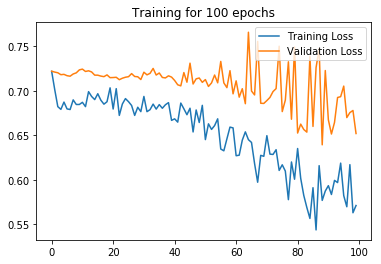

In [30]:
import matplotlib.pyplot as plt
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Training for ' +str(100)+ ' epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

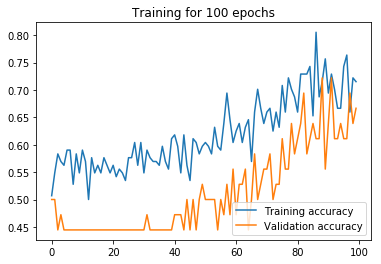

In [29]:
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Training for ' +str(100)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

In [19]:
score = model.evaluate(X_test, y_test, batch_size=16)
print(score)

18/18 [==============================] - 10s 574ms/step
[0.6519530879126655, 0.6666666666666666]


In [20]:
from PIL import Image
import os
def load_images_from_folder(folder):
    images = []
    images_idx = []
    for filename in os.listdir(folder):
        img = np.asarray(Image.open(os.path.join(folder,filename)))
        images.append(img)
        images_idx.append(filename)
    return images, images_idx
    
img , img_idx = load_images_from_folder('CROPTEST4/')
test = np.asarray(img)
print(test.shape)
# print(img_idx)
for i in range(400):
    print(img_idx[i])
# A=np.asarray(img)

(400, 597, 597, 3)
V0358.jpg
V0116.jpg
V0026.jpg
V0218.jpg
V0213.jpg
V0204.jpg
V0389.jpg
V0309.jpg
V0030.jpg
V0253.jpg
V0149.jpg
V0167.jpg
V0354.jpg
V0369.jpg
V0090.jpg
V0166.jpg
V0242.jpg
V0395.jpg
V0070.jpg
V0259.jpg
V0017.jpg
V0119.jpg
V0285.jpg
V0052.jpg
V0317.jpg
V0183.jpg
V0152.jpg
V0127.jpg
V0229.jpg
V0035.jpg
V0155.jpg
V0337.jpg
V0336.jpg
V0230.jpg
V0254.jpg
V0145.jpg
V0393.jpg
V0076.jpg
V0055.jpg
V0053.jpg
V0018.jpg
V0288.jpg
V0150.jpg
V0399.jpg
V0107.jpg
V0134.jpg
V0187.jpg
V0158.jpg
V0038.jpg
V0243.jpg
V0339.jpg
V0085.jpg
V0220.jpg
V0096.jpg
V0234.jpg
V0390.jpg
V0383.jpg
V0133.jpg
V0043.jpg
V0083.jpg
V0380.jpg
V0154.jpg
V0396.jpg
V0054.jpg
V0190.jpg
V0124.jpg
V0077.jpg
V0104.jpg
V0301.jpg
V0307.jpg
V0202.jpg
V0332.jpg
V0132.jpg
V0305.jpg
V0273.jpg
V0321.jpg
V0169.jpg
V0216.jpg
V0111.jpg
V0200.jpg
V0006.jpg
V0024.jpg
V0260.jpg
V0256.jpg
V0068.jpg
V0137.jpg
V0192.jpg
V0165.jpg
V0098.jpg
V0139.jpg
V0286.jpg
V0357.jpg
V0263.jpg
V0093.jpg
V0069.jpg
V0330.jpg
V0059.jpg
V0355.jpg
V

In [21]:
# test_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)

In [22]:
ans = model.predict(test, batch_size=1)
print(ans)
# model.predict_classes(test,batch_size=1)

[[0.40975863 0.64842886]
 [0.43438858 0.58373857]
 [0.40752316 0.6677743 ]
 [0.41273752 0.63083446]
 [0.61813813 0.35107592]
 [0.4192218  0.6220012 ]
 [0.46796903 0.53281146]
 [0.41151056 0.6423416 ]
 [0.4093234  0.6649778 ]
 [0.40692317 0.66181046]
 [0.40645546 0.65666234]
 [0.40642515 0.65287304]
 [0.40520903 0.6633193 ]
 [0.5391502  0.44704738]
 [0.43135583 0.5893885 ]
 [0.4433839  0.5663946 ]
 [0.45570627 0.56146973]
 [0.42337635 0.6046825 ]
 [0.40792555 0.661678  ]
 [0.44800916 0.56379795]
 [0.46664914 0.5300899 ]
 [0.40850613 0.6610377 ]
 [0.41656622 0.6294133 ]
 [0.4597833  0.54841614]
 [0.4699545  0.5386691 ]
 [0.40902618 0.6353482 ]
 [0.40592432 0.655693  ]
 [0.42379215 0.60108495]
 [0.5385727  0.4551783 ]
 [0.40796065 0.635168  ]
 [0.42952457 0.5816493 ]
 [0.39938852 0.67328644]
 [0.41952696 0.61061174]
 [0.39801314 0.66134727]
 [0.4103724  0.6466078 ]
 [0.40603948 0.66995794]
 [0.5237069  0.47451037]
 [0.40201387 0.66124934]
 [0.43661213 0.5686909 ]
 [0.41659778 0.60394347]


In [23]:
for list in ans:
    if list[1]<0.2:
        print(0.1)
        continue
    if list[1]<0.3:
        print(0.2)
        continue
    if list[1]<0.35:
        print(0.3)
        continue
    if list[1]<0.4:
        print(0.4)
        continue
    if list[1]<0.5:
        print(0.5)
        continue
    if list[1]<0.6:
        print(0.6)
        continue
    if list[1]<0.65:
        print(0.7)
        continue
    if list[1]<0.675:
        print(0.8)
        continue
    if list[1]<0.69:
        print(0.9)
        continue
    else:
        print(1.0)
        continue
        
    
    

0.7
0.6
0.8
0.7
0.4
0.7
0.6
0.7
0.8
0.8
0.8
0.8
0.8
0.5
0.6
0.6
0.6
0.7
0.8
0.6
0.6
0.8
0.7
0.6
0.6
0.7
0.8
0.7
0.5
0.7
0.6
0.8
0.7
0.8
0.7
0.8
0.5
0.8
0.6
0.7
0.5
0.6
0.8
0.7
0.6
0.7
0.8
0.7
0.6
0.8
0.8
0.6
0.7
0.6
0.8
0.6
0.9
0.7
0.8
0.7
0.6
0.7
0.8
0.8
0.8
0.8
0.7
0.6
0.6
0.6
0.7
0.6
0.6
0.6
0.6
0.6
0.5
0.7
0.8
0.6
0.8
0.8
0.7
0.2
0.6
0.7
0.8
0.6
0.7
0.6
0.6
0.8
0.6
0.6
0.6
0.8
0.8
0.6
0.8
0.6
0.7
0.6
0.6
0.6
0.7
0.6
0.7
0.6
0.8
0.5
0.7
0.8
0.8
0.5
0.6
0.6
0.8
0.7
0.6
0.8
0.6
0.7
0.6
0.6
0.6
0.8
0.7
0.6
0.6
0.6
0.6
0.8
0.7
0.6
0.8
0.8
0.6
0.6
0.8
0.8
0.8
0.6
0.8
0.8
0.6
0.6
0.5
0.9
0.9
0.6
0.6
0.8
0.6
0.6
0.7
0.7
0.6
0.6
0.6
0.8
0.6
0.8
0.6
0.6
0.6
0.6
0.7
0.6
0.6
0.7
0.6
0.8
0.8
0.8
0.6
0.8
0.6
0.6
0.8
0.7
0.7
0.6
0.8
0.6
0.8
0.5
0.8
0.5
0.7
0.7
0.6
0.7
0.7
0.7
0.6
0.6
0.6
0.6
0.7
0.5
0.6
0.6
0.6
0.6
0.8
0.8
0.7
0.8
0.8
0.7
0.6
0.7
0.6
0.6
0.6
0.7
0.7
0.7
0.6
0.7
0.8
0.8
0.6
0.7
0.7
0.7
0.5
0.8
0.6
0.8
0.7
0.7
0.8
0.6
0.7
0.6
0.6
0.3
0.6
0.5
0.6
0.6
0.6
0.7
0.7
0.6
0.6
0.5
0.8
0.7


# SVM

In [24]:
from keras.models import Model
model_feat = Model(inputs=model.input,outputs=model.get_layer('dense_4').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

feat_val = model_feat.predict(X_test)
print(feat_val.shape)

feat_test = model_feat.predict(test)
print(feat_test)

(72, 64)
(18, 64)
[[ 1.2678956e+01  2.4653076e+01 -5.6503592e+00 ...  1.0451949e+00
  -2.5555381e-01  1.8673443e+01]
 [ 1.3026114e+01  2.4065825e+01 -2.6811337e+00 ...  5.1489109e-01
  -3.2824278e+00  1.8612720e+01]
 [ 1.2223618e+01  2.4308950e+01 -9.5113611e+00 ...  2.1617699e+00
   3.2689579e+00  1.9590334e+01]
 ...
 [ 1.1228645e+01  2.1695574e+01 -6.1193142e+00 ...  5.0896317e-01
  -6.3591205e-02  1.5881155e+01]
 [ 1.1000071e+01  1.9154675e+01 -2.7994218e+00 ...  1.6098103e-02
  -2.6528153e+00  1.3994003e+01]
 [ 1.2920718e+01  2.4489964e+01 -3.4892817e+00 ...  1.3660105e+00
  -2.2838535e+00  1.9137104e+01]]


In [25]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(feat_train,np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


In [26]:
svm.score(feat_train,np.argmax(y_train,axis=1))

1.0

In [27]:
svm.score(feat_val,np.argmax(y_test,axis=1))

0.4444444444444444

In [28]:
Pred_labels = svm.predict(feat_test)
print(Pred_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# XGBOOST

In [31]:
import xgboost as xgb

xb = xgb.XGBClassifier()

xb.fit(feat_train,np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


In [32]:
xb.score(feat_train,np.argmax(y_train,axis=1))

/home/subodh_pushkar/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


1.0

In [33]:
xb.score(feat_val,np.argmax(y_test,axis=1))

/home/subodh_pushkar/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7222222222222222

In [35]:
Pred_labels = xb.predict(feat_test)
print(Pred_labels)

[1 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 0
 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0
 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 0 0 0 1
 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 1
 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1
 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1
 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1
 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0
 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0
 1 0 0 1 0 0 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0]


/home/subodh_pushkar/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
